# MSDS 455 - The Show
Created by: Lena Lu, Jacob Williams, James Moloznik, Nicholas Drake

## Genre

In [76]:
import pandas as pd
import numpy as np
import os
import kaggle
import glob
from time import sleep
import json
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import config
import spotipy.util as util
import matplotlib.pyplot as plt
import seaborn as sns
import math
from PIL import Image, ImageColor
import shutil
from IPython.display import Image, HTML
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Patch
from colorthief import ColorThief
import re
from slugify import slugify
from wordcloud import WordCloud, STOPWORDS

### Get data from Kaggle
To download csv file using Python, you will need a [Kaggle API Key](https://www.kaggle.com/docs/api). 

Make sure to save the API key in 'C:\Users\USER_NAME.kaggle' directory.

Data source used: [Spotify Top Chart Songs 2022](https://www.kaggle.com/datasets/sveta151/spotify-top-chart-songs-2022)

In [2]:
kaggle.api.authenticate()

In [4]:
# Top Spotify Tracks of 2022 Data Set
kaggle.api.dataset_download_files('sveta151/spotify-top-chart-songs-2022', '2022_spotify_top', unzip=True)

### Set up directory

In [48]:
ROOT = os.getcwd()
print(f"Root Directory: {ROOT}")

SPOTIFY_2022_DIR = os.path.join(ROOT, '2022_spotify_top')
print(f"Spotify 2022 Top Tracks Directory : {SPOTIFY_2022_DIR}")

Root Directory: C:\Users\Nicholas\Desktop\Masters - Classes\MSDS455\MSDS455-The_Show
Spotify 2022 Top Tracks Directory : C:\Users\Nicholas\Desktop\Masters - Classes\MSDS455\MSDS455-The_Show\2022_spotify_top


### Get alubm release data by genre for 2010-2023

In [6]:
album_release_df = pd.read_csv(os.path.join(ROOT, 'album_genre2010-23.csv'))
album_release_df.head()

,genre,count,year
0,Rock,55105,2010
1,Electronic,23524,2010
2,Pop,18516,2010
3,Folk/World/Country,14399,2010
4,Jazz,10493,2010


In [7]:
# Clean Genra
genere_other_ls = ['Classical', 'Jazz', 'Folk/World/Country', 'Latin', 'Blues', 'Stage & Screen', 'Reggae', 'Funk/Soul', 
                   'Non-Music', "Children's", 'Brass & Military']

genres_update_ls = []

for genre in album_release_df['genre']:
    if genre in genere_other_ls:
        genres_update_ls.append("Other")
    else:
        genres_update_ls.append(genre)
        
album_release_df['genres_update'] = genres_update_ls
album_release_df.head()

,genre,count,year,genres_update
0,Rock,55105,2010,Rock
1,Electronic,23524,2010,Electronic
2,Pop,18516,2010,Pop
3,Folk/World/Country,14399,2010,Other
4,Jazz,10493,2010,Other


In [8]:
album_release_df['genres_update'].unique()

array(['Rock', 'Electronic', 'Pop', 'Other', 'Hip Hop'], dtype=object)

### Bring in color palette

In [9]:
col_diverging = ['#7a0177','#c51b8a','#f768a1','#fa9fb5','#99d8c9','#66c2a4','#2ca25f','#006d2c']

sns.color_palette(col_diverging)

[(0.47843137254901963, 0.00392156862745098, 0.4666666666666667),
 (0.7725490196078432, 0.10588235294117647, 0.5411764705882353),
 (0.9686274509803922, 0.40784313725490196, 0.6313725490196078),
 (0.9803921568627451, 0.6235294117647059, 0.7098039215686275),
 (0.6, 0.8470588235294118, 0.788235294117647),
 (0.4, 0.7607843137254902, 0.6431372549019608),
 (0.17254901960784313, 0.6352941176470588, 0.37254901960784315),
 (0.0, 0.42745098039215684, 0.17254901960784313)]

In [10]:
genre_counts = album_release_df[['year', 'genres_update', 'count']]
genre_counts = genre_counts.groupby(['year', 'genres_update'], as_index=False).agg(count=("count", "sum"))

genre_counts.head()

,year,genres_update,count
0,2010,Electronic,23524
1,2010,Hip Hop,8091
2,2010,Other,47745
3,2010,Pop,18516
4,2010,Rock,55105


In [11]:
# drop 2018 and 2023 data as it is not complete
genre_counts = genre_counts[(genre_counts['year'] != 2018) & (genre_counts['year'] !=2023)]
genre_counts['year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2019, 2020, 2021,
       2022], dtype=int64)

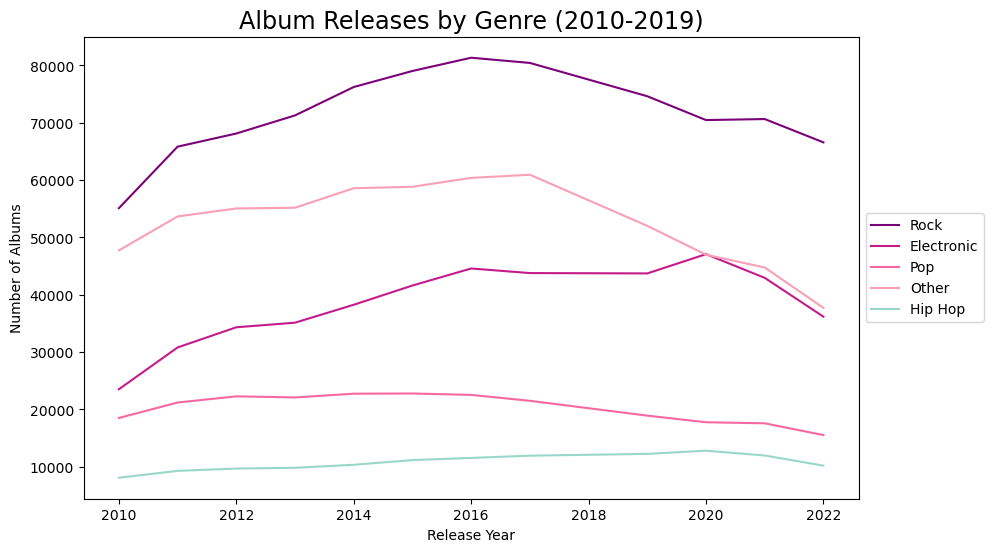

In [12]:
# Create a line plot
plt.figure(figsize=(10, 6))
for i, genre in enumerate(album_release_df['genres_update'].unique().tolist()):
    genre_data = genre_counts[genre_counts['genres_update'] == genre]
    plt.plot(genre_data['year'], genre_data['count'], label=genre, color=col_diverging[i])

# Customize the plot
plt.xlabel('Release Year')
plt.ylabel('Number of Albums')
plt.title('Album Releases by Genre (2010-2019)', fontsize = 'xx-large')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save plt as png file with transparent background
plt.savefig('2010s_Genre.png', transparent=True)

# Display the plot
plt.show()


### Spotify Top Tracks of 2022

In [13]:
src_files = glob.glob(os.path.join(SPOTIFY_2022_DIR, '*.csv'))
src_files

['C:\\Users\\Nicholas\\Desktop\\Masters - Classes\\MSDS455\\MSDS455-The_Show\\2022_spotify_top\\spotify_top_charts_22.csv']

In [14]:
spotify_2022_df = pd.read_csv(src_files[0])
print(len(spotify_2022_df))
spotify_2022_df.head()

646


,uri,artist_names,track_name,peak_rank,weeks_on_chart,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms
0,spotify:track:02MWAaffLxlfxAUY7c5dvx,Glass Animals,Heat Waves,1,65,0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,80.870,4,238805
1,spotify:track:5PjdY0CKGZdEuoNab3yDmX,"The Kid LAROI, Justin Bieber",STAY (with Justin Bieber),1,37,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.000000,0.1030,169.928,4,141806
2,spotify:track:3IAfUEeaXRX9s9UdKOJrFI,Anitta,Envolver,3,3,0.812,0.736,4,-5.421,0,0.0833,0.1520,0.002540,0.0914,91.993,4,193806
3,spotify:track:1HhNoOuqm1a5MXYEgAFl8o,"Imagine Dragons, JID, Arcane, League of Legends",Enemy (with JID) - from the series Arcane Leag...,3,21,0.728,0.783,11,-4.424,0,0.2660,0.2370,0.000000,0.4340,77.011,4,173381
4,spotify:track:4fouWK6XVHhzl78KzQ1UjL,GAYLE,abcdefu,1,19,0.695,0.540,4,-5.692,1,0.0493,0.2990,0.000000,0.3670,121.932,4,168602


### EDA

In [15]:
spotify_2022_df.describe()

,peak_rank,weeks_on_chart,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,65.922601,19.498452,0.674426,0.640836,5.086687,-6.356034,0.577399,0.109797,0.255699,0.013686,0.176478,121.091571,3.927245,203629.859133
std,57.004503,37.813937,0.151527,0.165478,3.622314,2.627462,0.494356,0.102167,0.262595,0.077836,0.133792,28.267951,0.351256,54966.666438
min,1.000000,1.000000,0.193000,0.021800,0.000000,-31.160000,0.000000,0.023200,0.000017,0.000000,0.026400,66.165000,1.000000,36935.000000
25%,15.000000,1.000000,0.569000,0.532500,1.000000,-7.716250,0.000000,0.041325,0.040400,0.000000,0.093100,98.428500,4.000000,169901.500000
50%,51.500000,5.000000,0.700000,0.652000,5.000000,-5.930500,1.000000,0.063450,0.155500,0.000002,0.120000,119.966000,4.000000,196388.500000
75%,108.750000,19.750000,0.790750,0.769000,8.000000,-4.595750,1.000000,0.135750,0.424500,0.000105,0.231750,139.968250,4.000000,229213.500000
max,200.000000,269.000000,0.985000,0.972000,11.000000,-0.514000,1.000000,0.611000,0.969000,0.908000,0.968000,205.863000,5.000000,613027.000000


In [16]:
# Check for Nulls
print(spotify_2022_df.isnull().sum())

uri                 0
artist_names        0
track_name          0
peak_rank           0
weeks_on_chart      0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
tempo               0
time_signature      0
duration_ms         0
dtype: int64


In [17]:
# Unique tracks
print(f"Number of unique tracks: {len(spotify_2022_df['track_name'].unique())}")

Number of unique tracks: 646


### Clean data

In [18]:
# Get track ID from URI Column
spotify_2022_df['track_id'] = spotify_2022_df['uri'].str.split(':').str[2]
spotify_2022_df.head()

,uri,artist_names,track_name,peak_rank,weeks_on_chart,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms,track_id
0,spotify:track:02MWAaffLxlfxAUY7c5dvx,Glass Animals,Heat Waves,1,65,0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,80.870,4,238805,02MWAaffLxlfxAUY7c5dvx
1,spotify:track:5PjdY0CKGZdEuoNab3yDmX,"The Kid LAROI, Justin Bieber",STAY (with Justin Bieber),1,37,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.000000,0.1030,169.928,4,141806,5PjdY0CKGZdEuoNab3yDmX
2,spotify:track:3IAfUEeaXRX9s9UdKOJrFI,Anitta,Envolver,3,3,0.812,0.736,4,-5.421,0,0.0833,0.1520,0.002540,0.0914,91.993,4,193806,3IAfUEeaXRX9s9UdKOJrFI
3,spotify:track:1HhNoOuqm1a5MXYEgAFl8o,"Imagine Dragons, JID, Arcane, League of Legends",Enemy (with JID) - from the series Arcane Leag...,3,21,0.728,0.783,11,-4.424,0,0.2660,0.2370,0.000000,0.4340,77.011,4,173381,1HhNoOuqm1a5MXYEgAFl8o
4,spotify:track:4fouWK6XVHhzl78KzQ1UjL,GAYLE,abcdefu,1,19,0.695,0.540,4,-5.692,1,0.0493,0.2990,0.000000,0.3670,121.932,4,168602,4fouWK6XVHhzl78KzQ1UjL


### Run track data through Spotify API
- Documentation: [Spotify API](https://developer.spotify.com/documentation/web-api)

In [19]:
# Spotify API Auth
client_id = config.client_id
client_secret = config.client_secret
username = config.username

redirect_uri = 'http://localhost:7777/callback'
# scope = 'user-top-read'

auth_token = util.prompt_for_user_token(username=username, 
#                                    scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

In [20]:
trak_id_ls = spotify_2022_df['track_id'].tolist()
trak_id_ls[:5]

['02MWAaffLxlfxAUY7c5dvx',
 '5PjdY0CKGZdEuoNab3yDmX',
 '3IAfUEeaXRX9s9UdKOJrFI',
 '1HhNoOuqm1a5MXYEgAFl8o',
 '4fouWK6XVHhzl78KzQ1UjL']

In [21]:
# function to divide a list of uris (or ids) into chuncks of 50.
chunker = lambda y, x: [y[i : i + x] for i in range(0, len(y), x)]

# using the chunker function
track_chunks = chunker(trak_id_ls, 50)

In [22]:
track_data = []

for track in track_chunks:
    base_url = 'https://api.spotify.com/v1/tracks?ids='

    #2. Authentication
    #3. Parameters -- would be stored with authentication
    headers = {
        "Authorization": f"Bearer {auth_token}"
    }

    #4. Create an empty list
    r = requests.get(base_url+",".join(track), headers=headers)
    track_data.append(json.loads(r.text))
    sleep(3)

len(track_data)

13

In [23]:
# Get album release date
album_release_ls = []

# Get artist ID
artist_ids = []

for i in range(0, len(track_data)):
    for x in range(0, len(track_data[i]['tracks'])):
        album_release_ls.append(track_data[i]['tracks'][x]['album']['release_date'])
        artist_ids.append(track_data[i]['tracks'][x]['artists'][0]['id'])

display(len(album_release_ls))
display(len(artist_ids))

646

646

### Get artist data for genre

In [24]:
# using the function
artist_chunks = chunker(artist_ids, 50)

In [25]:
artist_data = []

for artist in artist_chunks:
    base_url = 'https://api.spotify.com/v1/artists?ids='

    #2. Authentication
    #3. Parameters -- would be stored with authentication
    headers = {
        "Authorization": f"Bearer {auth_token}"
    }

    #4. Create an empty list
    r = requests.get(base_url+",".join(artist), headers=headers)
    artist_data.append(json.loads(r.text))
    sleep(3)
    
len(artist_data)

13

In [26]:
# Get genres
genre_ls = []

for i in range(0, len(artist_data)):
    for x in range(0, len(artist_data[i]['artists'])):
        if len(artist_data[i]['artists'][x]['genres']) == 0:
            genre_ls.append("No Genre Listed")
        else:
            genre_ls.append(artist_data[i]['artists'][x]['genres'][0])
        
len(genre_ls)

646

### Join data back to main table

In [27]:
spotify_2022_df['album_release'] = album_release_ls
spotify_2022_df['genre'] = genre_ls

spotify_2022_df.head()

,uri,artist_names,track_name,peak_rank,weeks_on_chart,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms,track_id,album_release,genre
0,spotify:track:02MWAaffLxlfxAUY7c5dvx,Glass Animals,Heat Waves,1,65,0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,80.870,4,238805,02MWAaffLxlfxAUY7c5dvx,2020-08-06,gauze pop
1,spotify:track:5PjdY0CKGZdEuoNab3yDmX,"The Kid LAROI, Justin Bieber",STAY (with Justin Bieber),1,37,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.000000,0.1030,169.928,4,141806,5PjdY0CKGZdEuoNab3yDmX,2021-07-23,australian hip hop
2,spotify:track:3IAfUEeaXRX9s9UdKOJrFI,Anitta,Envolver,3,3,0.812,0.736,4,-5.421,0,0.0833,0.1520,0.002540,0.0914,91.993,4,193806,3IAfUEeaXRX9s9UdKOJrFI,2021-11-11,funk pop
3,spotify:track:1HhNoOuqm1a5MXYEgAFl8o,"Imagine Dragons, JID, Arcane, League of Legends",Enemy (with JID) - from the series Arcane Leag...,3,21,0.728,0.783,11,-4.424,0,0.2660,0.2370,0.000000,0.4340,77.011,4,173381,1HhNoOuqm1a5MXYEgAFl8o,2021-09-03,modern rock
4,spotify:track:4fouWK6XVHhzl78KzQ1UjL,GAYLE,abcdefu,1,19,0.695,0.540,4,-5.692,1,0.0493,0.2990,0.000000,0.3670,121.932,4,168602,4fouWK6XVHhzl78KzQ1UjL,2021-08-13,modern alternative pop


In [28]:
# Check Genres
spotify_2022_df['genre'].value_counts()

pop                          80
reggaeton                    44
dance pop                    32
canadian contemporary r&b    27
k-pop                        24
                             ..
pop rap                       1
modern indie pop              1
irish singer-songwriter       1
cali rap                      1
indie pop                     1
Name: genre, Length: 169, dtype: int64

### Simplify Genres

In [29]:
genre_rock_ls = ["alternative rock",
"modern rock",
"american post-rock",
"idol rock",
"modern alternative rock",
"piano rock",
"experimental rock",
"indie rock",
"christian alternative rock",
"dutch rock",
"celtic rock",
"modern folk rock",
"classic garage rock",
"future rock",
"modern blues rock",
"english indie rock",
"australian alternative rock",
"canadian rock",
"dance rock",
"album rock",
"british post-rock",
"alternative pop rock",
"irish rock",
"danish alternative rock",
"german hard rock",
"atmospheric post-rock",
"french rock",
"australian post-rock",
"boston rock",
"modern country rock",
"alternative roots rock",
"dark rock",
"southern rock",
"blues-rock guitar",
"christian hard rock",
"instrumental math rock",
"german post-rock",
"swedish alternative rock",
"heartland rock",
"german indie rock",
"deep classic garage rock",
"finnish alternative rock",
"deep christian rock",
"garage rock",
"austin rock",
"classic rock",
"comedy rock",
"medieval rock",
"acoustic rock",
"chinese indie rock",
"belgian rock",
"modern southern rock",
"indie rock italiano",
"hard rock",
"indie rock italiano",
"boston indie",
"chicago indie",
"cologne indie",
"indie curitibano",
"indie siciliano",
"indie triste"]

genre_pop_ls = ["dance pop",
"pop",
"art pop",
"canadian pop",
"desi pop",
"pop rap",
"hip pop",
"barbadian pop",
"electropop",
"neon pop punk",
"baroque pop",
"britpop",
"dream pop",
"indie pop rap",
"post-teen pop",
"acoustic pop",
"folk-pop",
"latin pop",
"candy pop",
"colombian pop",
"french folk pop",
"collage pop",
"french indie pop",
"pop r&b",
"canadian pop punk",
"k-pop",
"australian pop",
"dutch pop",
"german pop",
"bubblegum pop",
"metropopolis",
"country pop",
"electropowerpop",
"chamber pop",
"bedroom pop",
"puerto rican pop",
"bitpop",
"alternative pop rock",
"experimental pop",
"danish pop",
"pop soul",
"bow pop",
"power pop",
"pop dance",
"chicago pop punk",
"australian electropop",
"viral pop",
"classic pakistani pop",
"vintage dutch pop",
"electro-pop francais",
"channel pop",
"nederpop",
"pop punk",
"romanian pop",
"social media pop",
"belgian pop",
"austrian pop",
"alternative pop",
"czech pop",
"israeli pop",
"boy pop",
"canadian electropop",
"mandopop",
"australian alternative pop",
"indie dream pop",
"teen pop",
"classic swedish pop",
"classic city pop",
"indie poptimism",
"brill building pop",
"finnish pop",
"panamanian pop",
"nyc pop",
"funk pop",
"modern alternative pop",
"gauze pop",
"pop reggaeton",
"chill pop",
"pop venezolano",
"scandipop",
"ambient pop",
"pop nacional",
"pop reggaeton",
"italian adult pop",
"k-pop girl group",
"pop venezolano",
"ambient pop",
"chill pop",
"indie pop",
"modern indie pop",
"pop nacional",
"pop reggaeton",
"scandipop",
"uk pop",
"agronejo"]

genre_hiphop_ls = ["atl hip hop",
"hip hop",
"canadian hip hop",
"conscious hip hop",
"desi hip hop",
"detroit hip hop",
"east coast hip hop",
"boston hip hop",
"instrumental hip hop",
"alternative hip hop",
"latin hip hop",
"australian hip hop",
"christian hip hop",
"memphis hip hop",
"abstract hip hop",
"ohio hip hop",
"lgbtq+ hip hop",
"north carolina hip hop",
"bronx hip hop",
"experimental hip hop",
"brazilian hip hop",
"uk hip hop",
"kentucky hip hop",
"hawaiian hip hop",
"drumless hip hop",
"southern hip hop",
"miami hip hop",
"asian american hip hop",
"arkansas hip hop",
"french hip hop",
"australian underground hip hop",
"german hip hop",
"ghanaian hip hop",
"deep german hip hop",
"maine hip hop",
"finnish hip hop",
"deep underground hip hop",
"kansas city hip hop",
"lgbtq+ hip hop",
"deep underground hip hop",
"hawaiian hip hop",
"ukrainian hip hop",
"argentine hip hop",
"italian hip hop",
"brazilian hip hop",
"gambian hip hop",
"turkish hip hop",
"uk hip hop"]

genre_folk_country_ls = ["folk-pop",
"french folk pop",
"modern folk rock",
"australian indie folk",
"folk punk",
"ambient folk",
"american folk revival",
"british folk",
"appalachian folk",
"folk metal",
"canadian folk",
"rune folk",
"folk",
"german indie folk",
"indie folk",
"arab folk",
"contemporary country",
"classic oklahoma country",
"australian country",
"classic texas country",
"arkansas country",
"country rap",
"alternative country",
"country road",
"country pop",
"country dawn",
"modern country rock",
"country gospel",
"alberta country",
"country"]

genre_rb_ls = ["r&b",
"canadian contemporary r&b",
"contemporary r&b",
"pop r&b",
"afro r&b",
"alternative r&b",
"experimental r&b",
"chill r&b",
"uk contemporary r&b",
"british soul",
"neo soul",
"chicago soul",
"pop soul",
"indie soul",
"bedroom soul",
"vapor soul",
"afro r&b",
"indie r&b",
"indonesian r&b",
"r&b brasileiro",
"r&b en espanol",
"afrobeats",
"funk carioca"
]

genre_rap_ls = ["melodic rap",
"chicago rap",
"pop rap",
"dfw rap",
"emo rap",
"dirty south rap",
"cali rap",
"gangster rap",
"san diego rap",
"baton rouge rap",
"indie pop rap",
"new jersey rap",
"country rap",
"rap",
"houston rap",
"bass trap",
"comedy rap",
"florida rap",
"cloud rap",
"viral trap",
"trap",
"scam rap",
"battle rap",
"nyc rap",
"gospel rap",
"k-rap",
"trap queen",
"alabama rap",
"upstate ny rap",
"german alternative rap",
"new orleans rap",
"sad rap"]

genre_electronic_ls = ["canadian electronic",
"electronica",
"uk experimental electronic",
"bulgarian electronic",
"bristol electronic",
"vintage french electronic",
"dutch experimental electronic",
"frankfurt electronic",
"reggaeton"]

genre_jazz_ls = ["contemporary vocal jazz",
"contemporary jazz",
"acid jazz",
"ecm-style jazz",
"cool jazz",
"avant-garde jazz",
"german jazz",
"dark jazz",
"jazz saxophone",
"jazz trio",
"jazz piano",
"jazztronica",
"norwegian jazz",
"canadian modern jazz",
"electro jazz",
"british jazz",
"jazz guitar",
"french jazz",
"dutch jazz",
"norwegian contemporary jazz",
"indonesian jazz"]

genre_classical_ls = ["21st century classical",
"baltic classical",
"american contemporary classical",
"classical",
"chinese classical",
"african-american classical",
"classical countertenor",
"american modern classical",
"neo-classical",
"ukrainian classical piano",
"british contemporary classical",
"early modern classical",
"caucasian classical",
"classical piano",
"austrian contemporary classical",
"classical saxophone",
"danish contemporary classical",
"canadian classical",
"contemporary classical"]

genre_punk_ls = ["cyberpunk",
"neon pop punk",
"danspunk",
"chicago punk",
"anarcho-punk",
"acoustic punk",
"boston punk",
"crust punk",
"canadian pop punk",
"folk punk",
"dark post-punk",
"art punk",
"canadian punk",
"chicago pop punk",
"elektropunk",
"pop punk",
"dance-punk",
"french punk",
"australian garage punk",
"christian punk",
"modern ska punk",
"dreampunk",
"german punk",
"early french punk",
"american post-punk"]

genre_metal_ls = ["alternative metal",
"death metal",
"german metal",
"black metal",
"atmospheric black metal",
"christian metal",
"doom metal",
"gothenburg metal",
"birmingham metal",
"greek metal",
"brutal death metal",
"chilean metal",
"austrian metal",
"cyber metal",
"danish metal",
"comic metal",
"avant-garde metal",
"belgian metal",
"french death metal",
"australian metal",
"chinese metal",
"finnish death metal",
"austrian black metal",
"autonomous black metal",
"finnish heavy metal",
"avant-garde black metal",
"alabama metal",
"chilean black metal",
"french metal",
"danish death metal",
"german heavy metal",
"finnish black metal",
"dark black metal",
"symphonic black metal",
"brazilian doom metal",
"atmospheric post-metal",
"finnish doom metal",
"boston metal",
"indonesian death metal",
"brazilian death metal",
"canadian death metal",
"ambient black metal",
"folk metal",
"black speed metal",
"swiss metal",
"american metalcore",
"brazilian black metal",
"metallic hardcore",
"fantasy metal",
"grisly death metal",
"experimental black metal",
"brazilian metal",
"british black metal",
"australian metalcore",
"gothic metal",
"irish metal",
"greek black metal",
"colombian black metal",
"atlanta metal",
"australian thrash metal",
"proto-metal",
"florida death metal",
"drone metal",
"german metalcore",
"lovecraftian metal",
"german thrash metal",
"grim death metal",
"canadian metalcore",
"melodic metalcore",
"russian death metal",
"gothic symphonic metal",
"norwegian doom metal",
"italian death metal",
"glam metal"]

In [30]:
genres_simple = []

for genre in spotify_2022_df['genre']:
    if genre in genre_pop_ls:
        genres_simple.append("Pop")
    elif genre in genre_hiphop_ls:
        genres_simple.append("Hip Hop")
    elif genre in genre_rock_ls:
        genres_simple.append("Rock")
    elif genre in genre_rb_ls:
        genres_simple.append("Funk / Soul")
    elif genre in genre_rap_ls:
        genres_simple.append("Rap")
    elif genre in genre_folk_country_ls:
        genres_simple.append("Folk, World, & Country")
    elif genre in genre_metal_ls:
        genres_simple.append("Metal")
    elif genre in genre_punk_ls:
        genres_simple.append("Punk")
    elif genre in genre_classical_ls:
        genres_simple.append("Classical")
    elif genre in genre_jazz_ls:
        genres_simple.append("Jazz")
    elif genre in genre_electronic_ls:
        genres_simple.append("Electronic")
    else:
        genres_simple.append("Other")
        
genres_simple[:10]

['Pop',
 'Hip Hop',
 'Pop',
 'Rock',
 'Pop',
 'Other',
 'Pop',
 'Hip Hop',
 'Pop',
 'Pop']

In [31]:
spotify_2022_df['genres_update'] = genres_simple

spotify_2022_df.head()

,uri,artist_names,track_name,peak_rank,weeks_on_chart,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms,track_id,album_release,genre,genres_update
0,spotify:track:02MWAaffLxlfxAUY7c5dvx,Glass Animals,Heat Waves,1,65,0.761,0.525,11,-6.900,1,...,0.4400,0.000007,0.0921,80.870,4,238805,02MWAaffLxlfxAUY7c5dvx,2020-08-06,gauze pop,Pop
1,spotify:track:5PjdY0CKGZdEuoNab3yDmX,"The Kid LAROI, Justin Bieber",STAY (with Justin Bieber),1,37,0.591,0.764,1,-5.484,1,...,0.0383,0.000000,0.1030,169.928,4,141806,5PjdY0CKGZdEuoNab3yDmX,2021-07-23,australian hip hop,Hip Hop
2,spotify:track:3IAfUEeaXRX9s9UdKOJrFI,Anitta,Envolver,3,3,0.812,0.736,4,-5.421,0,...,0.1520,0.002540,0.0914,91.993,4,193806,3IAfUEeaXRX9s9UdKOJrFI,2021-11-11,funk pop,Pop
3,spotify:track:1HhNoOuqm1a5MXYEgAFl8o,"Imagine Dragons, JID, Arcane, League of Legends",Enemy (with JID) - from the series Arcane Leag...,3,21,0.728,0.783,11,-4.424,0,...,0.2370,0.000000,0.4340,77.011,4,173381,1HhNoOuqm1a5MXYEgAFl8o,2021-09-03,modern rock,Rock
4,spotify:track:4fouWK6XVHhzl78KzQ1UjL,GAYLE,abcdefu,1,19,0.695,0.540,4,-5.692,1,...,0.2990,0.000000,0.3670,121.932,4,168602,4fouWK6XVHhzl78KzQ1UjL,2021-08-13,modern alternative pop,Pop


In [32]:
spotify_2022_df_count = spotify_2022_df['genres_update'].value_counts().rename_axis('genres_update').reset_index(name='spotify_counts')
spotify_2022_df_count

,genres_update,spotify_counts
0,Pop,236
1,Hip Hop,124
2,Other,120
3,Funk / Soul,48
4,Electronic,44
5,Rap,36
6,Rock,30
7,"Folk, World, & Country",5
8,Metal,2
9,Jazz,1


### Bring in 2020 album release data

In [33]:
spotify_2022_df_count

,genres_update,spotify_counts
0,Pop,236
1,Hip Hop,124
2,Other,120
3,Funk / Soul,48
4,Electronic,44
5,Rap,36
6,Rock,30
7,"Folk, World, & Country",5
8,Metal,2
9,Jazz,1


In [34]:
test_df = genre_counts[genre_counts['year'] == 2022]

In [35]:
genre_2022 = test_df.merge(spotify_2022_df_count, on='genres_update', how='left')
genre_2022['spotify_counts'] = genre_2022['spotify_counts'].fillna(0)
genre_2022['spotify_counts'] = genre_2022['spotify_counts'].astype(int)
genre_2022

,year,genres_update,count,spotify_counts
0,2022,Electronic,36179,44
1,2022,Hip Hop,10199,124
2,2022,Other,37709,120
3,2022,Pop,15529,236
4,2022,Rock,66586,30


In [36]:
total_2022_albums = sum(genre_2022['count'])
total_2022_albums

166202

In [37]:
total_2022_top_albums = sum(genre_2022['spotify_counts'])
total_2022_top_albums

554

In [38]:
genre_2022['% of all Albums'] = (genre_2022['count']/total_2022_albums)*100
genre_2022['% of top Albums'] = (genre_2022['spotify_counts']/total_2022_top_albums)*100

genre_2022

,year,genres_update,count,spotify_counts,% of all Albums,% of top Albums
0,2022,Electronic,36179,44,21.768089,7.942238
1,2022,Hip Hop,10199,124,6.136509,22.382671
2,2022,Other,37709,120,22.688656,21.660650
3,2022,Pop,15529,236,9.343450,42.599278
4,2022,Rock,66586,30,40.063296,5.415162


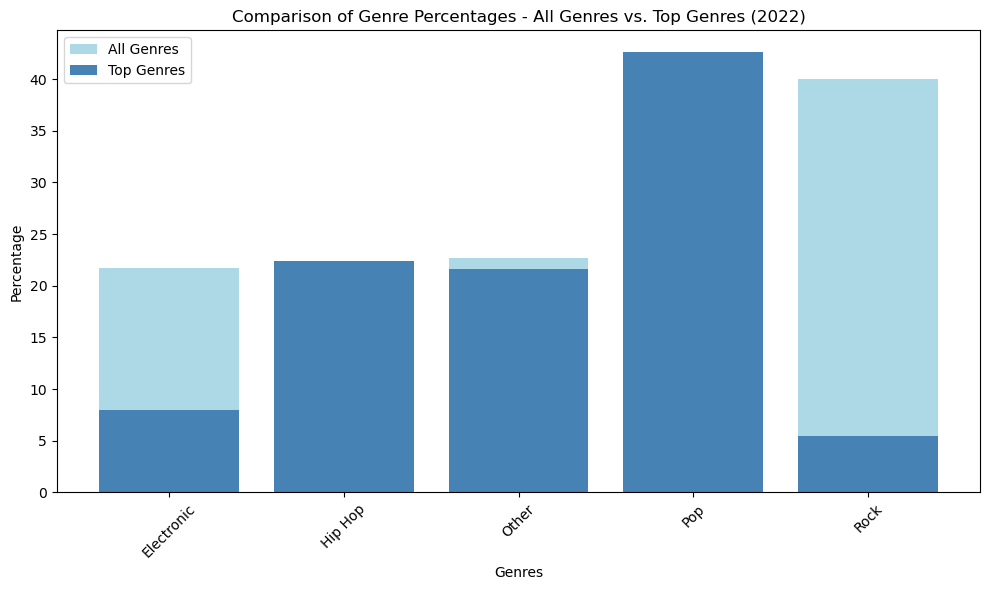

In [39]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for all genres
ax.bar(genre_2022['genres_update'], genre_2022['% of all Albums'], label='All Genres', color='lightblue')

# Plot the bars for top genres
ax.bar(genre_2022['genres_update'], genre_2022['% of top Albums'], label='Top Genres', color='steelblue')

# Set the title and labels
ax.set_title('Comparison of Genre Percentages - All Genres vs. Top Genres (2022)')
ax.set_xlabel('Genres')
ax.set_ylabel('Percentage')

# Add a legend
ax.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()
plt.show()

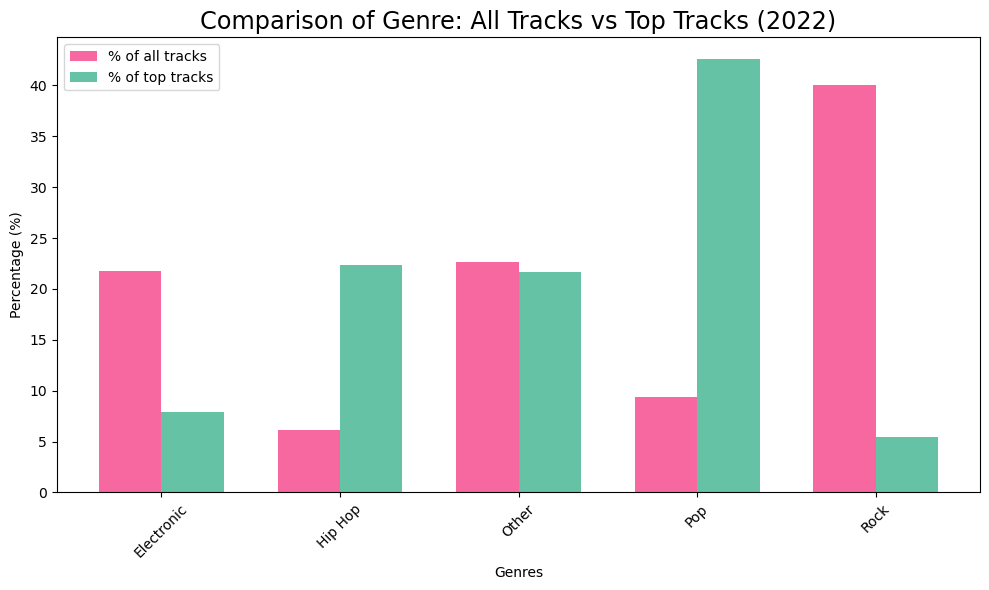

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of each bar
bar_width = 0.35

# Calculate the positions of the left side of the bars
bar_positions = np.arange(len(genre_2022['genres_update']))

# Plot the bars for all genres
ax.bar(genre_2022['genres_update'], genre_2022['% of all Albums'], label='% of all tracks', width=bar_width, color='#f768a1')

# Plot the bars for top genres
ax.bar(bar_positions + bar_width, genre_2022['% of top Albums'], label='% of top tracks', width=bar_width, color='#66c2a4')

# Set the title and labels
ax.set_title('Comparison of Genre: All Tracks vs Top Tracks (2022)', fontsize = 'xx-large')
ax.set_xlabel('Genres')
ax.set_ylabel('Percentage (%)')

# Add a legend
ax.legend()

# Set the x-axis ticks and labels
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(genre_2022['genres_update'])

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
col_diverging = ['#7a0177','#c51b8a','#f768a1','#fa9fb5','#99d8c9','#66c2a4','#2ca25f','#006d2c']

sns.color_palette(col_diverging)

### Look into track attributes for all pop songs

In [43]:
spotify_2022_pop = spotify_2022_df[spotify_2022_df['genres_update'] == "Pop"]
spotify_2022_pop.head()

,uri,artist_names,track_name,peak_rank,weeks_on_chart,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,tempo,time_signature,duration_ms,track_id,album_release,genre,genres_update
0,spotify:track:02MWAaffLxlfxAUY7c5dvx,Glass Animals,Heat Waves,1,65,0.761,0.525,11,-6.900,1,...,0.4400,0.000007,0.0921,80.870,4,238805,02MWAaffLxlfxAUY7c5dvx,2020-08-06,gauze pop,Pop
2,spotify:track:3IAfUEeaXRX9s9UdKOJrFI,Anitta,Envolver,3,3,0.812,0.736,4,-5.421,0,...,0.1520,0.002540,0.0914,91.993,4,193806,3IAfUEeaXRX9s9UdKOJrFI,2021-11-11,funk pop,Pop
4,spotify:track:4fouWK6XVHhzl78KzQ1UjL,GAYLE,abcdefu,1,19,0.695,0.540,4,-5.692,1,...,0.2990,0.000000,0.3670,121.932,4,168602,4fouWK6XVHhzl78KzQ1UjL,2021-08-13,modern alternative pop,Pop
6,spotify:track:1ri9ZUkBJVFUdgwzCnfcYs,"Becky G, KAROL G",MAMIII,5,6,0.843,0.700,4,-3.563,0,...,0.0934,0.000000,0.1400,93.991,4,226088,1ri9ZUkBJVFUdgwzCnfcYs,2022-02-10,latin pop,Pop
8,spotify:track:6mmPpaltUZK7xjNlBPQQ0p,"Rauw Alejandro, Chencho Corleone",Desesperados,8,15,0.869,0.694,1,-3.350,0,...,0.3560,0.001250,0.0878,90.020,4,224997,6mmPpaltUZK7xjNlBPQQ0p,2021-12-10,puerto rican pop,Pop


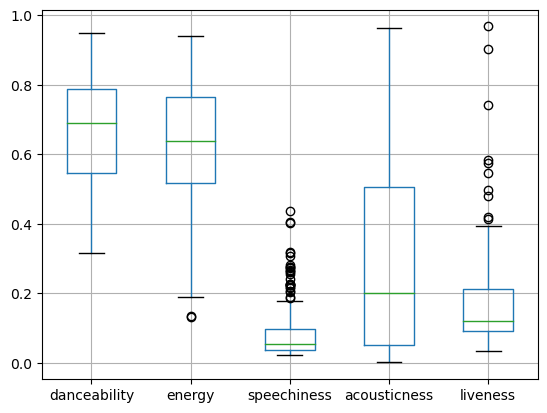

In [44]:
spotify_2022_pop[['danceability', 'energy', 'speechiness', 'acousticness', 'liveness']].boxplot();

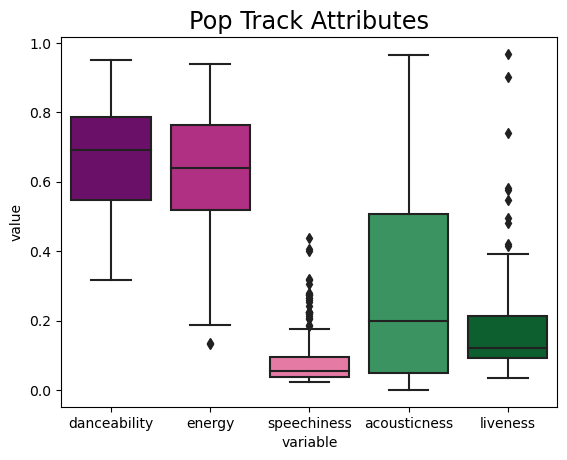

In [45]:
%matplotlib inline

#Setting chosen theme color palette for this visualization
sns.set_palette(sns.color_palette(['#7a0177','#c51b8a','#f768a1','#2ca25f','#006d2c']))


box_df = spotify_2022_pop[['danceability', 'energy', 'speechiness', 'acousticness', 'liveness']]

sns.boxplot(x="variable", y="value", data=pd.melt(box_df))

plt.title('Pop Track Attributes', fontsize = 'xx-large')

plt.show()

## Identity

### Main Color of Top 5 Best Selling Albums Since 1990

#### Define Functions

In [77]:
def str_formatter(x):
    x = re.sub('\t', '', x)
    x = re.sub('\n', '', x)
    return x

In [78]:
#Web scraping web archives (odd rows)
def archive_odd(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('table', class_ = 'cbbTable_rowOn')[index]
        #Returns the gray rows in the table, odd rows
    album_cover = album.find_all(class_='cbbTable_c2')[0].find_all('img')[0].attrs['src']
        #Returns image link
    img_url = url_prefix + album_cover
        #Returns full image link
    album_artist = album.find_all('div', class_='cbbTable_text3')[0].text
        #Returns artist name
    album_artist = str_formatter(album_artist)
        #Returns artist name without formatting
    album_name = album.find_all('div', class_='cbbTable_text4')[0].text
        #Returns album name
    album_name = str_formatter(album_name)
        #Returns album name without formatting
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [79]:
#Web scraping web archives (even rows)
def archive_even(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('table', class_ = 'cbbTable_rowOff')[index]
        #Returns the white rows in the table, even rows
    album_cover = album.find_all(class_='cbbTable_c2')[0].find_all('img')[0].attrs['src']
        #Returns image link
    img_url = url_prefix + album_cover
        #Returns full image link
    album_artist = str_formatter(album.find_all('div', class_='cbbTable_text3')[0].text)
        #Returns artist name
    album_name = str_formatter(album.find_all('div', class_='cbbTable_text4')[0].text)
        #Returns album name
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [80]:
#Web scraping current Billboards

def billboards(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('div', class_ = 'o-chart-results-list-row-container')[index]
        #Returns each row
    img_url = album.find_all('li', class_ = 'o-chart-results-list__item')[1].find('img').attrs['data-lazy-src']
        #Returns image link
    album_artist = str_formatter(album.find_all('span')[1].text)
        #Returns artist name
    album_name = str_formatter(album.find('h3').text)
        #Returns album name
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [81]:
#Saves images
def save_image(img_url):
    r = requests.get(img_url, stream=True) #Get request on full_url
    if r.status_code == 200:                     #200 status code = OK
       with open(f"album covers/{file_name}.jpg", 'wb') as f: 
          r.raw.decode_content = True
          shutil.copyfileobj(r.raw, f)

https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image

In [82]:
#Convert rgb to hexcode
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

#Dominant color
def colorthief(album_name):
    global album_color
    color_thief = ColorThief(f'album covers/{album_name}.jpg')
    dominant_color = color_thief.get_color(quality=1)
    album_color = rgb_to_hex(dominant_color)

In [83]:
#Append to dataframe
def df_append(y):
    global df_albums
    df_row = [album_name, album_artist, year, y, f'<img src="album covers/{file_name}.jpg"/>', album_color]
    df = pd.DataFrame(df_row).transpose()
    df.columns = ['Album', 'Artist', 'Release Year', 'Rank', 'Cover', 'Color']
    df_albums = pd.concat([df_albums.loc[:], df]).reset_index(drop=True)

### Generates Dataframe of Top 5 Selling Albums 1990 - 2022

In [84]:
user_agent = {'User-agent': 'Mozilla/5.0'}
df_albums = pd.DataFrame(columns = ['Album', 'Artist', 'Release Year', 'Rank', 'Cover', 'Color'])

for year in range(1990, 2023):
    if year < 2002:
        url = f"https://web.archive.org/web/20071222015019/http://www.billboard.com/bbcom/charts/yearend_chart_display.jsp?f=The+Billboard+200&g=Year-end+Albums&year={year}"
        r = requests.get(url, headers = user_agent)
        soup = BeautifulSoup(r.text,"html.parser")
        url_prefix = 'https://web.archive.org'

        try:
            for y in np.array([1,2,3,4,5]):
                if y in np.array([1,3,5]):
                    index = int(y/2)
                    archive_odd(index)
                else:
                    index = int(y/2-1)
                    archive_even(index)
        except:
            pass
    else:
        url = f"https://www.billboard.com/charts/year-end/{year}/top-billboard-200-albums/"

        r = requests.get(url, headers = user_agent)
        soup = BeautifulSoup(r.text,"html.parser")

        for y in np.array([1,2,3,4,5]):
            index = int(y-1)
            billboards(index)

FileNotFoundError: [Errno 2] No such file or directory: 'album covers/the-eminem-show.jpg'

In [ ]:
HTML(df_albums.to_html(escape=False))

### Visualization

In [ ]:
%matplotlib inline

plt.figure(figsize = (18,6))

color_list = list(df_albums.sort_values(by = ['Rank', 'Release Year'])['Color'])

plt.imshow(colors.to_rgba_array(color_list).reshape(5,32,4))
plt.xticks(ticks = range(0,32), labels = list(df_albums['Release Year'].unique()), rotation = 30)
plt.yticks(ticks = range(0,5), labels = [1, 2, 3, 4, 5])
plt.xlabel('Year')
plt.ylabel('Album Rank')
plt.title('Dominant Color for Best Selling Albums 1990-2022')
plt.show()

### Main Color of Billboard's Best Albums of All Time
https://www.billboard.com/photos/best-album-covers-of-all-time-6715351

In [ ]:
#Load in the CSV file created from the website
best_covers = pd.read_csv('best_album_covers.csv', encoding='cp1252')
best_covers.sort_values(by = 'Rank', inplace = True)
best_covers.reset_index(inplace = True, drop = True)

best_covers.head()

In [ ]:
df_cover = pd.DataFrame(columns = ['Cover', 'Color'])

for x in range(1,51):
    global df_cover
    img_url = best_covers[best_covers['Rank'] == x]['Link'].iloc[0]
    file_name = f"Cover Rank {x}"
    save_image(img_url)
        #Open the URL to the cover and save into album covers folder
    
    colorthief(file_name)
        #Obtain dominant color of album cover
    
    df_row = [f'<img src="album covers/{file_name}.jpg"/>', album_color]
    df = pd.DataFrame(df_row).transpose()
    df.columns = ['Cover', 'Color']
    df_cover = pd.concat([df_cover.loc[:], df]).reset_index(drop=True)
        #Save into a dataframe

### Creating Dataframe

In [ ]:
best_covers[['Cover', 'Color']] = df_cover
HTML(best_covers.to_html(escape=False))

### Creating Visualization

In [ ]:
%matplotlib inline

plt.figure(figsize = (15,2.5))

color_list = list(best_covers['Color'])

plt.subplot(2, 1, 1)
plt.imshow(colors.to_rgba_array(color_list[0:25]).reshape(1,25,4))
plt.tick_params(left = False, labelleft = False)
plt.xticks(ticks = range(0,25), labels = list(range(1,26)), rotation = 30)

plt.subplot(2, 1, 2)
plt.imshow(colors.to_rgba_array(color_list[25:51]).reshape(1,25,4))
plt.tick_params(left = False, labelleft = False)
plt.xticks(ticks = range(0,25), labels = list(range(26,51)), rotation = 30)
plt.xlabel('Rank')

plt.suptitle('Main Color of Billboard\'s Top 50 Album Covers')
plt.show()

### Spotify Hit vs Miss Songs Dataset (2010s)
https://www.kaggle.com/datasets/theoverman/the-spotify-hit-predictor-dataset/code

Column definitions from https://developer.spotify.com/documentation/web-api/reference/get-audio-features

In [ ]:
spotify_df = pd.read_csv('dataset-of-10s.csv')
spotify_df.head()

In [ ]:
#Adding a labeled categorical column for Target aka Hit or Miss

conditions = [
    (spotify_df['target'] == 0),
    (spotify_df['target'] == 1)
]

values = ['Miss', 'Hit']

spotify_df['Success'] = np.select(conditions, values)

In [ ]:
spotify_df.head()

### Exploratory Data Analysis

In [ ]:
spotify_df.info()

In [ ]:
spotify_df.describe()

In [ ]:
%matplotlib inline

fig = spotify_df.hist(figsize = (16,12))

In [ ]:
corr = spotify_df.corr(method = 'pearson')
plt.figure(figsize = (12,8))
sns.heatmap(corr.abs())

In [ ]:
%matplotlib inline

fig, axes = plt.subplots(3,4, sharex = True, figsize = (15,12), constrained_layout=True)
sns.boxplot(ax = axes[0,0], data = spotify_df, x = 'Success', y = 'danceability', showfliers = False)
sns.boxplot(ax = axes[0,1], data = spotify_df, x = 'Success', y = 'energy', showfliers = False)
sns.boxplot(ax = axes[0,2], data = spotify_df, x = 'Success', y = 'loudness', showfliers = False)
sns.boxplot(ax = axes[0,3], data = spotify_df, x = 'Success', y = 'key', showfliers = False)
sns.boxplot(ax = axes[1,0], data = spotify_df, x = 'Success', y = 'speechiness', showfliers = False)
sns.boxplot(ax = axes[1,1], data = spotify_df, x = 'Success', y = 'acousticness', showfliers = False)
sns.boxplot(ax = axes[1,2], data = spotify_df, x = 'Success', y = 'instrumentalness', showfliers = False)
sns.boxplot(ax = axes[1,3], data = spotify_df, x = 'Success', y = 'chorus_hit', showfliers = False)
sns.boxplot(ax = axes[2,0], data = spotify_df, x = 'Success', y = 'liveness', showfliers = False)
sns.boxplot(ax = axes[2,1], data = spotify_df, x = 'Success', y = 'valence', showfliers = False)
sns.boxplot(ax = axes[2,2], data = spotify_df, x = 'Success', y = 'tempo', showfliers = False)
sns.boxplot(ax = axes[2,3], data = spotify_df, x = 'Success', y = 'duration_ms', showfliers = False)

In [ ]:
#Converting ms to minutes for easier interpretation

spotify_df['Duration (mins)'] = spotify_df['duration_ms']/60000

In [ ]:
%matplotlib inline

#Setting chosen theme color palette for this visualization
sns.set_palette(sns.color_palette(['#1EC98D','#D14343']))

fig, axes = plt.subplots(1,5, figsize = (18,4))
plt.subplots_adjust(wspace=0.4, hspace=0.3)
sns.boxplot(ax = axes[0], data = spotify_df, x = 'Success', y = 'danceability', showfliers = False).set(title = 'Danceability')
sns.boxplot(ax = axes[1], data = spotify_df, x = 'Success', y = 'loudness', showfliers = False).set(title = 'Loudness (dB)')
sns.boxplot(ax = axes[2], data = spotify_df, x = 'Success', y = 'acousticness', showfliers = False).set(title = 'Acousticness')
#sns.boxplot(ax = axes[1,0], data = spotify_df, x = 'Success', y = 'instrumentalness', showfliers = False).set(ylabel = 'Instrumentalness')
sns.boxplot(ax = axes[3], data = spotify_df, x = 'Success', y = 'valence', showfliers = False).set(title = 'Valence')
sns.boxplot(ax = axes[4], data = spotify_df, x = 'Success', y = 'Duration (mins)', showfliers = False).set(title = 'Duration (mins)')

plt.suptitle('Defining Differences Between Hit and Miss Songs', verticalalignment = 'bottom', y = 0.97, fontsize = 'xx-large')

patch_hit = Patch(color = '#1EC98D', label = 'Hit', ec = 'black')
patch_miss = Patch(color = '#D14343', label = 'Miss', ec = 'black')

plt.figlegend(handles = [patch_hit, patch_miss], loc = 'lower center', handleheight = 1, frameon = False, ncol = 2)

for ax in axes:
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()

### Lyrics Analysis
Using the Genius.com API https://lyricsgenius.readthedocs.io/en/master/index.html

#### Text Cleansing Functions

In [ ]:
def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def remove_punctuation_space(text: str) -> str:
    return re.sub('[^a-zA-Z|\s]', '', str(text))

def replace_line_break(text: str) -> str:
    return re.sub('\n', ' ', str(text))

def remove_symbols(text: str) -> str:
    return re.sub('[(\'"-,.?!)]', '', str(text))

def clean_text(text: str) -> str:
    text = replace_line_break(text)
    text = remove_punctuation_space(text)
    text = remove_tags(text)
    text = remove_symbols(text)
    return text

#### Sampling

In [ ]:
#Sampling hit songs 

hits = spotify_df[spotify_df['target']==1][['track', 'artist']].sample(n=100, random_state = 44)
hits.head()

In [ ]:
#Removing features for better searching 

hits['main artist'] = hits['artist'].str.split(' Featuring').str[0]

hits['lyrics'] = '' #adding empty column for lyrics later

hits.head()

### Setting up API

In [ ]:
#pip install lyricsgenius

from lyricsgenius import Genius

token = '2N2g5mQnfOduTA74y4VkVAGAOkz-quq-F5wdJ-hfrxjKg2W1Rpqjz9k2WAI-cjZW'

genius = Genius(token, timeout = 200, verbose = False, remove_section_headers = True)

### Generating DataFrame

In [ ]:
hits.reset_index(drop = True, inplace = True)

In [ ]:
#Generating lyric search

for i in range(0, len(hits)):
    songs = genius.search_songs(hits.loc[i,'track'] +' '+ hits.loc[i,'main artist'])
    hits.loc[i,'lyrics'] = genius.lyrics(song_url = songs['hits'][0]['result']['url'])

In [ ]:
#Checking to make sure all the data loaded in properly

hits['length'] = hits['lyrics'].str.len()
plt.hist(hits['length'])

In [ ]:
#Some songs look suspiciously short

hits[hits['length'] < 1000]

In [ ]:
#Prayer C is not correct

hits.loc[15, 'lyrics']

In [ ]:
#Finding the correct version

songs = genius.search_songs('Prayer in C')
genius.lyrics(song_url = songs['hits'][0]['result']['url'])

In [ ]:
#Prayer C is not correct

hits.loc[15, 'lyrics'] = genius.lyrics(song_url = songs['hits'][0]['result']['url'])

hits['length'] = hits['lyrics'].str.len()
    #Recalculating length

#### Cleaning the Data

In [ ]:
#Removing the header

hits['cleaned_lyrics'] = hits['lyrics'].str.split('Lyrics\n').str[1]

In [ ]:
#Removing the word Embed at the end
hits['cleaned_lyrics'] = hits['cleaned_lyrics'].str.split('Embed').str[0]

In [ ]:
hits.head()

In [ ]:
hits['cleaned_lyrics'] = hits['cleaned_lyrics'].str.lower()

for i in range(0, len(hits)):
    hits.loc[i, 'cleaned_lyrics'] = clean_text(hits.loc[i,'cleaned_lyrics'])

In [ ]:
#Creating a text string of all the lyrics
text = ''
for i in range(0, len(hits)):
    lyrics = hits.loc[i, 'cleaned_lyrics']
    text = lyrics + ' ' + text

### WordCloud

In [ ]:
col_diverging = ['#7a0177','#c51b8a','#f768a1','#fa9fb5','#fcc5c0','#feebe2', '#edf8fb','#ccece6','#99d8c9','#66c2a4','#2ca25f','#006d2c']

In [ ]:
%matplotlib inline

def color(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=44, **kwargs):
    return ImageColor.getcolor(col_diverging[random.randint(0,len(col_diverging)-1)], 'RGB')


stopwords = set(STOPWORDS)
stopwords.add('yeah')
stopwords.add('im')
stopwords.add('ive')
stopwords.add('ill')
stopwords.add('oh')
stopwords.add('ayy')
stopwords.add('ooh')
stopwords.add('uh')
stopwords.add('woah')
stopwords.add('er')
stopwords.add('got')

wordcloud = WordCloud(width = 1000, height = 500, max_words = 100, background_color = '#152235',
                      color_func =  color, stopwords = stopwords, normalize_plurals = True, collocations = False).generate(text)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Commerce

In [51]:
#import data
df = pd.read_csv("musicdata.csv")
df.shape
df.describe(include="all")

,format,metric,year,number_of_records,value_actual
count,3008,3008,3008.000000,3008.0,1351.000000
unique,24,3,NaN,NaN,NaN
top,CD,Value,NaN,NaN,NaN
freq,141,1081,NaN,NaN,NaN
mean,NaN,NaN,1996.000000,1.0,781.291237
std,NaN,NaN,13.566915,0.0,2246.837672
min,NaN,NaN,1973.000000,1.0,-7.650944
25%,NaN,NaN,1984.000000,1.0,3.700228
50%,NaN,NaN,1996.000000,1.0,63.900000
75%,NaN,NaN,2008.000000,1.0,448.900000


In [52]:
#Filter out before 1980
df = df[df['year'] >= 1980]

In [53]:
# Drop uneeded column and fill null values
df = df.drop(columns = ["number_of_records"]) 
df.value_actual = df.value_actual.fillna(0)

In [54]:
#remove negative valuyes, fix spelling
df.loc[df.value_actual < 0, "value_actual"] = 0 
df.loc[df["format"] == "Paid Subscriptions", "format"] = "Paid Subscription" 

In [55]:
df.format.unique()

array(['CD', 'CD Single', 'Cassette', 'Cassette Single', 'LP/EP',
       'Vinyl Single', '8 - Track', 'Other Tapes',
       'Music Video (Physical)', 'DVD Audio', 'SACD', 'Download Single',
       'Download Album', 'Kiosk', 'Download Music Video',
       'Ringtones & Ringbacks', 'Paid Subscription',
       'Limited Tier Paid Subscription',
       'On-Demand Streaming (Ad-Supported)',
       'Other Ad-Supported Streaming', 'Other Digital',
       'SoundExchange Distributions', 'Synchronization'], dtype=object)

In [56]:
#reogranize format groups
df['format'] = df['format'].replace(['CD Single'], 'CD')
df['format'] = df['format'].replace(['Cassette Single'], 'Cassette')
df['format'] = df['format'].replace(['Limited Tier Paid Subscription'], 'Paid Subscription')
df['format'] = df['format'].replace(['Other Tapes'], 'Cassette')
df['format'] = df['format'].replace(['Download Album'], 'Download')
df['format'] = df['format'].replace(['Download Single'], 'Download')
df['format'] = df['format'].replace(['Download Music Video'], 'Music Video')
df['format'] = df['format'].replace(['Music Video (Physical)'], 'Music Video')
df['format'] = df['format'].replace(['Other Ad-Supported Streaming'], 'Streaming')
df['format'] = df['format'].replace(['On-Demand Streaming (Ad-Supported)'], 'Streaming')
df['format'] = df['format'].replace(['SACD'], 'CD')

In [57]:
#grouping by year andf format
grouped_df1 = df.groupby(['year', 'format'])['value_actual'].sum()

In [58]:
#grouby year
grouped_df2 = df.groupby(['year'])['value_actual'].sum()

In [59]:
#pushing data into pd and resetting index
grouped_df1 = pd.DataFrame(grouped_df1)
grouped_df2 = pd.DataFrame(grouped_df2)

grouped_df1.reset_index(inplace = True)
grouped_df2.reset_index(inplace = True)

In [60]:
#merge data
grouped_df_final = pd.merge(grouped_df1, grouped_df2, left_on =['year'], right_on = 'year', how = 'left')

In [61]:
#calculate % value
grouped_df_final['percent_value']= grouped_df_final['value_actual_x'] / grouped_df_final['value_actual_y']

In [62]:
#unstacking df for graphing
grouped_df_final = grouped_df_final.groupby(['year', 'format'])['percent_value'].mean().unstack()

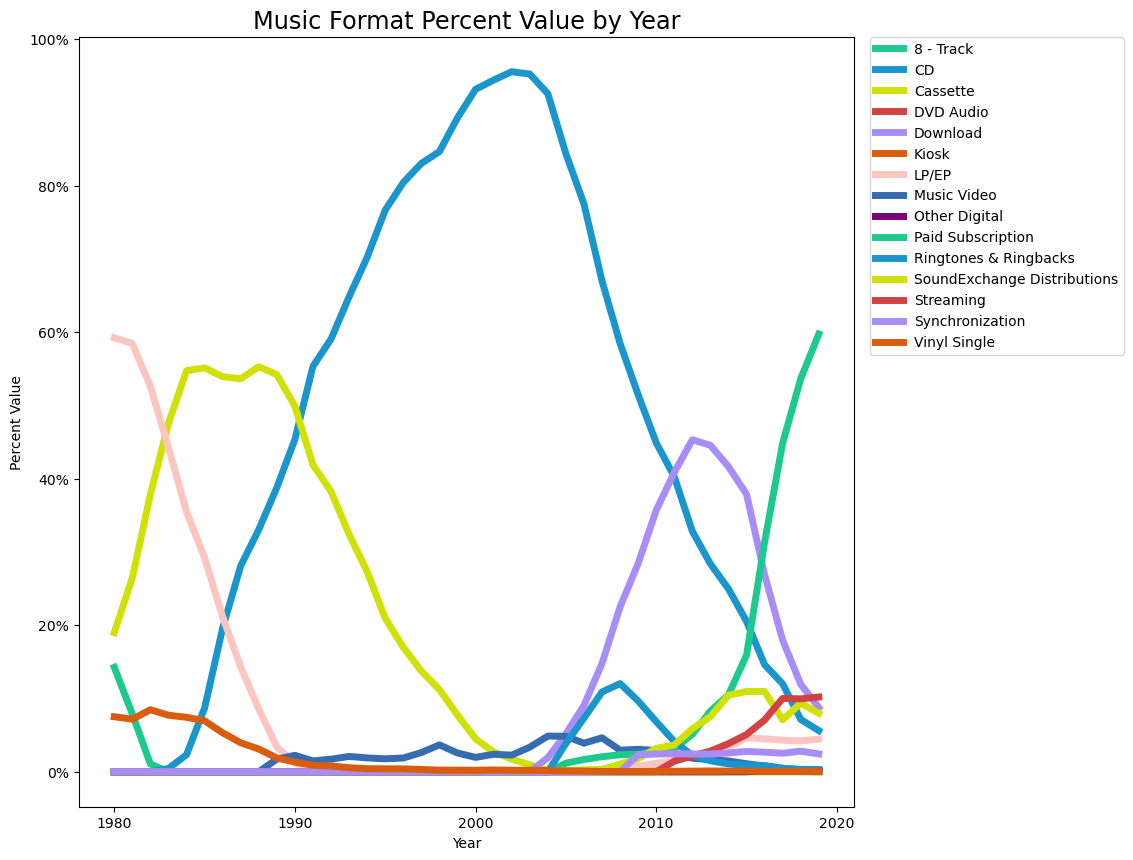

In [63]:
#PLot graph using color scheme
import matplotlib.ticker as ticker

colors = ['#1EC98D', '#1B96CD', '#D1E107', '#D14343', '#A98DF7', '#D95C0F', '#fcc5c0', '#386cb0', '#7A0177']

fig, ax = plt.subplots(figsize=(10, 10))

# Create bar plot using color scheme and loop through scheme if more colors needed
for i, col in enumerate(grouped_df_final.columns):
    if i < len(colors):
        ax.plot(grouped_df_final.index, grouped_df_final[col], color=colors[i], linewidth=5)
    else:
        color_index = i % len(colors)
        ax.plot(grouped_df_final.index, grouped_df_final[col], color=colors[color_index], linewidth=5)

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percent Value')
plt.title('Music Format Percent Value by Year', fontsize = 'xx-large')
# Format y labels as percentage
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# Set the x label interval
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

plt.legend(grouped_df_final.columns, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.show()

In [66]:
df = pd.read_csv("vinyldata.csv")
df.head()

,year,Retail value of LP / EP shipments (million U.S. dollars)
0,1999,"1,093.40"
1,2000,653.70
2,2001,396.80
3,2002,238.80
4,2003,164.20


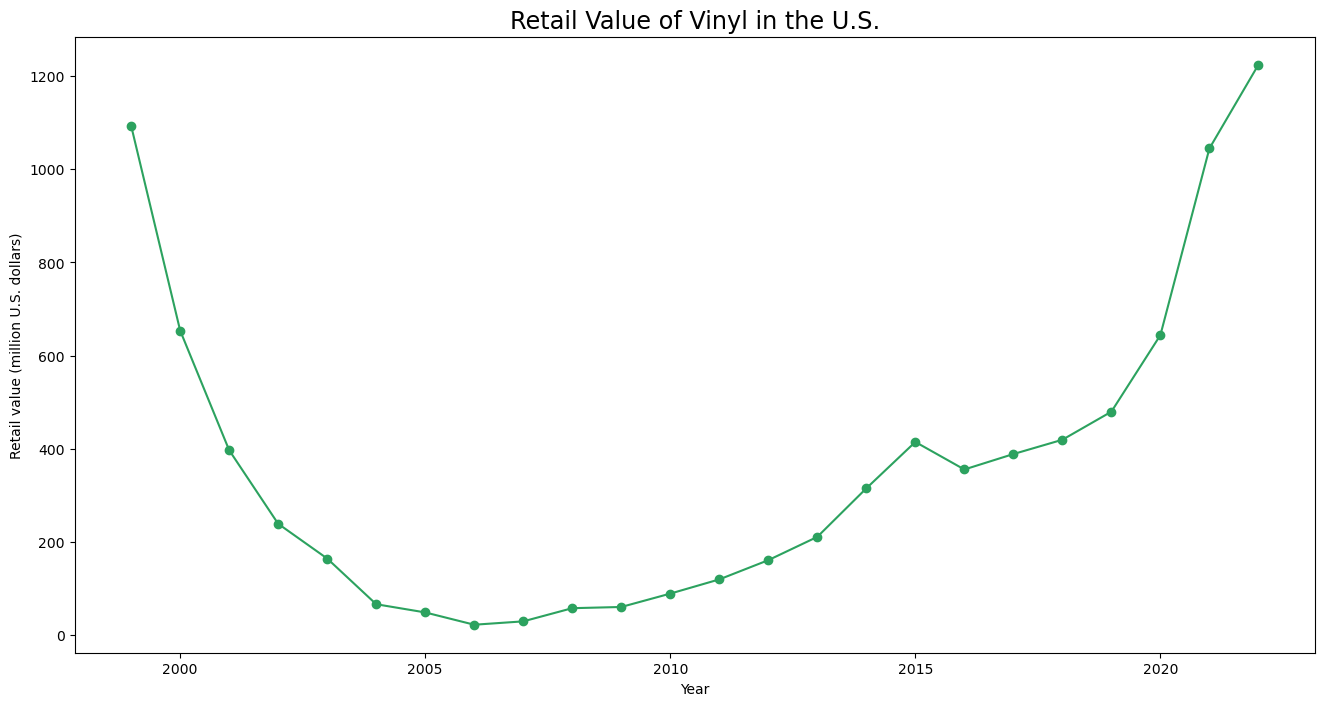

In [67]:
# Convert value column to number
df['Retail value of LP / EP shipments (million U.S. dollars)'] = df['Retail value of LP / EP shipments (million U.S. dollars)'].str.replace(',', '').astype(float)

#Plot graph
plt.figure(figsize=(16, 8)) 
plt.plot(df['year'], df['Retail value of LP / EP shipments (million U.S. dollars)'], marker='o', color='#2ca25f')

# Set labels/title
plt.xlabel('Year')
plt.ylabel('Retail value (million U.S. dollars)')
plt.title('Retail Value of Vinyl in the U.S.', fontsize = 'xx-large')



plt.show()

In [69]:
df = pd.read_excel('ticketdata.xlsx')
df.head()

,Rank,Artist,Revenue,Tickets Sold,Shows
0,1,Bad Bunny,435.18,2477334,81
1,2,Elton John,391.62,2421594,92
2,3,Coldplay,342.27,3802812,64
3,4,Ed Sheeran,247.01,3046063,62
4,5,Harry Styles,244.01,1900975,78


In [71]:
# Calculate the column averages
avg_shows = df['Shows'].mean()
avg_tickets_sold = df['Tickets Sold'].mean()

# Create new columns by dividing each row value by the column average
df['shows_x'] = df['Shows'] / avg_shows
df['tickets_sold_y'] = df['Tickets Sold'] / avg_tickets_sold

#Remove uneeded data
df = df.iloc[:-10]

df.head()

,Rank,Artist,Revenue,Tickets Sold,Shows,shows_x,tickets_sold_y
0,1,Bad Bunny,435.18,2477334,81,1.615155,1.512026
1,2,Elton John,391.62,2421594,92,1.834497,1.478005
2,3,Coldplay,342.27,3802812,64,1.276171,2.321023
3,4,Ed Sheeran,247.01,3046063,62,1.236291,1.859146
4,5,Harry Styles,244.01,1900975,78,1.555334,1.160248


In [72]:
#sort descending for formatting
df = df.sort_values("tickets_sold_y",ascending=False )

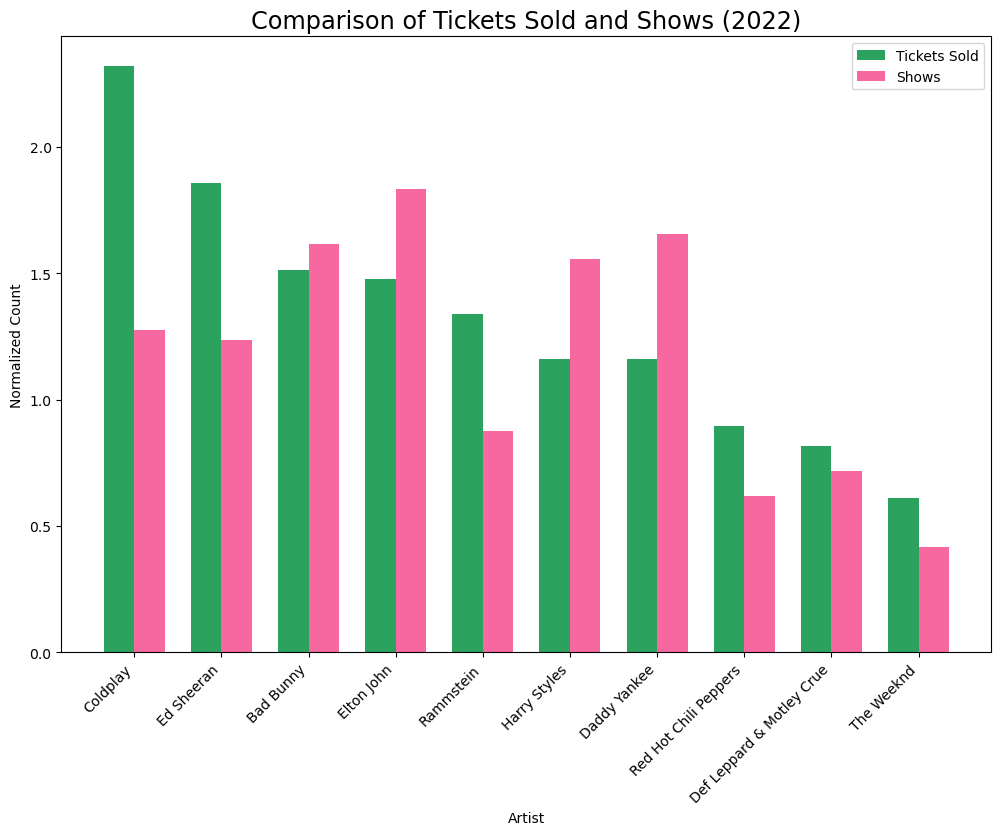

In [73]:
# Set plot
plt.figure(figsize=(12, 8))

# Set the position of each bar 
r1 = np.arange(len(df['Artist']))
r2 = [x + bar_width for x in r1]

# Create bar chart
plt.bar(r1, df['tickets_sold_y'], color='#2ca25f', width=bar_width, label='Tickets Sold')
plt.bar(r2, df['shows_x'], color='#f768a1', width=bar_width, label='Shows')

# Rotate Tickers
plt.xticks([r + bar_width/2 for r in range(len(df['Artist']))], df['Artist'], rotation=45, ha='right')

# Set labels and title
plt.xlabel('Artist')
plt.ylabel('Normalized Count')
plt.title('Comparison of Tickets Sold and Shows (2022)', fontsize = 'xx-large')

plt.legend()

plt.show()

## Cross-Media